In [227]:
# tests for points routines
# 2018/12/11 from test documentation for points module,
# most is removed. This investigates rotation of 2D arrays in order
# to develop correct 2D rotation functions.

# original notes (?not sure what was removed and what was not incorporated ever):
# sphinx
# kernel must be reset and output cleared before use or before running
# sphinx (unless you know what you are doing).

## TODO 
# - sphinxuse _build for intermediate files (move to docs\_build)
# but save output in docs(or move it there).
# - hide parts of code, add doc string above commands.
# - save the results in the noteook (this anyway will prevent 
#   future executions, so maybe make a copy or a script to clear output
#   when sphinx is called).

%reset
%load_ext autoreload
%autoreload 2

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np

#from pySurf.points import *
import os
import logging
import pdb

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
from IPython.display import display
from astropy.io import fits
import itertools
from itertools import product

from dataIO.fn_add_subfix import fn_add_subfix
from dataIO.span import span, span_from_pixels
from dataIO.outliers import remove_outliers
from dataIO.functions import strip_kw,pop_kw

from scipy import ndimage
from scipy.ndimage import map_coordinates
from scipy import interpolate as ip

from plotting.captions import legendbox
from plotting.add_clickable_markers import add_clickable_markers2

from pySurf.testSurfaces import make_prof_legendre, make_surf_legendre
from pySurf.points import points_in_poly,rotate_points
from pySurf.find_internal_rectangle import find_internal_rectangle

from pySurf.data2D import plot_data,rotate_data

In [229]:
#avoid the annoying inline figures 
%matplotlib qt 

from IPython.display import display
plt.ioff()

In [230]:
#%qtconsole
plt.close('all')

In [5]:
%qtconsole

In [593]:
def test_rotate(a,rotang):
    """use ndimage.rotate with different options to 
    rotate a shape clockwise of a given angle with resample flag on and off, compare results.
    There is no coordinates manipulation.
    This is needed to understand how to handle axis in implementing rotation in data2D (data with axis).
    Note that rotation happens on pixels and it is mapped to pixels, so it is always integer."""
    plt.close('all')
    
    nx,ny = a.shape

    ax1=plt.subplot(311)
    plt.imshow(a,origin='lower',interpolation='none');plt.title("raw; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
    plt.colorbar()

    ax2=plt.subplot(312)
    a2=ndimage.rotate(a,rotang,reshape=0)
    plt.imshow(a2,origin='lower',interpolation='none')
    plt.title("reshape=0; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%
    (plt.xlim()+plt.ylim()))
    plt.colorbar()

    ax3=plt.subplot(313)
    a3=ndimage.rotate(a,rotang,reshape=1)
    plt.imshow(a3,origin='lower',interpolation='none')
    plt.title("reshape=1; xlim: %.2f:%.2f,ylim: %.2f:%.2f"
    %(plt.xlim()+plt.ylim()))
    plt.colorbar()
    plt.tight_layout(rect=[0,0,1,0.95])

    plt.suptitle("expected projected side lengths %.3f, %.3f"%(nx*np.cos(rotang*np.pi/180)+ny*np.sin(15*np.pi/180),ny*np.cos(rotang*np.pi/180)+nx*np.sin(rotang*np.pi/180)))
    
    return ax1,ax2,ax3



Use `scipy.ndimage.interpolation.rotate` with different options.
Original data (top) is a rectangle of 2's (green) in a rectangle of 1's (blue).
When image is rotated, 0 is used as fill value (can be set with parameter `cval`) for points out of the original image.
`reshape` controls if the rotated data are cropped after rotation to match original range (`reshape = False`).

A small square of 3's (yellow) is inserted at coordinates [10:15,20:25] to identify axis orientation by marking the corner closer to 0 in x and y (imshow must be called with origin='lower' to orient axis as cartesian, and also to put axis limits in increasing order). 
Four central pixels are marked with a value of 10, as well as the single point at 20,10.

This is automatically handled in `pySurf.data2D` functions.

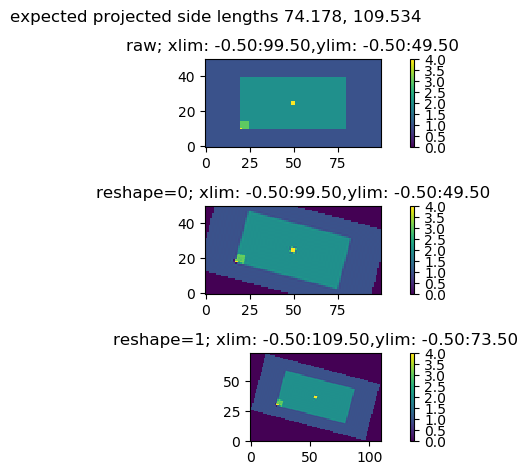

In [232]:
#build test array

nx,ny=100,50
a=np.ones(nx*ny).reshape((ny,nx))
a[10:-10,20:-20]=2
a[10:15,20:25]=3
a[10,20]=10
a[(ny//2-1):(ny//2+1),(nx//2-1):(nx//2+1)]=10

rotang=15 # rotation angle in degrees

axes=test_rotate(a,rotang)
for ax in axes:
    plt.sca(ax)
    plt.clim([0,4])
display(plt.gcf())

Regarding the lateral sampling, `reshape = False` keeps same number of points (and same sampling).
`reshape = True` increases the number of points to cover the entire rotated data.

In [233]:
print("shape of a:",a.shape)
print("shapes of images data in figure:")
for ax in axes:
    plt.sca(ax)
    print(ax.images[0].get_size())

shape of a: (50, 100)
shapes of images data in figure:
(50, 100)
(50, 100)
(74, 110)


In [234]:
ax1,ax2,ax3=axes
a1,a2,a3=[ax.images[0].get_array() for ax in axes]

Reasonably, both methods should preserve 
We can verify how well they maintain pixel size. The single corner is marked with the out of range value of 10, that spreads to nearby pixel in interpolation. 

In [235]:
plt.close('all')

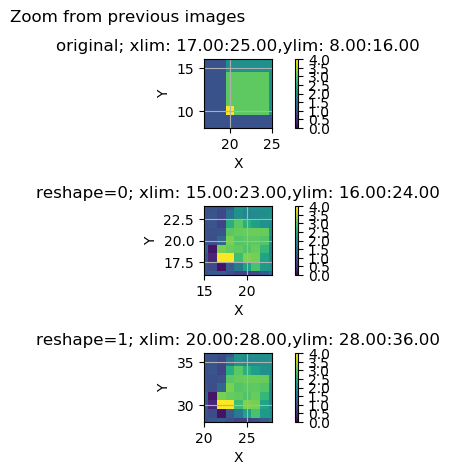

In [236]:
plt.figure()

ax1=plt.subplot(311)
plot_data(a1,vmin=0,vmax=4)
ax1.set_xlim([17,25])
ax1.set_ylim([8,16])
plt.title("original; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
plt.grid(1)

ax2=plt.subplot(312)
plot_data(a2,vmin=0,vmax=4)
ax2.set_xlim([15,23])
ax2.set_ylim([16,24])
plt.title("reshape=0; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
plt.grid(1)

ax3=plt.subplot(313)
plot_data(a3,vmin=0,vmax=4)
ax3.set_xlim([20,28])
ax3.set_ylim([28,36])
plt.title("reshape=1; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
plt.grid(1)
plt.tight_layout(rect=[0,0,1,0.95])

#plt.suptitle("expected projected side lengths %.3f, %.3f"%(nx*np.cos(rotang*np.pi/180)+ny*np.sin(15*np.pi/180),ny*np.cos(rotang*np.pi/180)+nx*np.sin(rotang*np.pi/180)))
plt.suptitle("Zoom from previous images")
plt.show()
display(plt.gcf())

It was seen that sampling is preserved very well, this also reasonably maintains the amount of information, since density of information is maintained. 

The rotated image has an integer number of pixels, that doesn't match perfectly the non-integer positions of the rotated pixels (including corners). This can be taken care with interpolation, however it also poses some doubt about lateral registration. Notice that it is not easy to intuitively define the rotation center, most simply corresponds to a rotation about the center followed by x and y translations to bring the corners to 0.
The ambiguity is in how the non-integer rotated coordinates are mapped to array indices:
How does for example an interval of 109.534 (projected distance between rotated corners) maps to an integer distance of 109 pixels? Is it centered (accurate for center of rotation at array center) or aligned to the left?

Is the center calculated from min and max or from all four corners or from all pixels?
 

## Step by step rotate function

These are the functions in pySurf that can be useful.

Use `rotate_points` as well tested reference:

In [472]:
from pySurf.affine2D import rotate_points, find_affine, rototrans_func
print(rotate_points.__doc__,'\n---\n')
print(find_affine.__doc__,'\n---\n')
print(rototrans_func.__doc__)

returns rotated coordinates of 2D point(s) x ([Npoints x 2]) about a center with anticlockwise angle theta in rad. If 3D points are passed, z coordinate is maintained. 
---

Return a function that can transform points from the first system to the second. 
    if pars is set to a list, append the matrix A of the transformation, that can be applied to a vector x with:
    unpad(np.dot(pad(x), A))
    markers1 and markers2 are sets of points in format [Npoints, Ndim]. Transformation matrix A is [Ndim+1 x Ndim+1].
    
    http://stackoverflow.com/questions/20546182/how-to-perform-coordinates-affine-transformation-using-python-part-2
     
---

return a function that rotate by theta about center THEN translate by offset


In [473]:
#try to deal with x and y

#establish data coordinates if not provided
if x is None: 
    x=np.arange(data.shape[1],dtype=float)
if y is None:
    y=np.arange(data.shape[0],dtype=float)

corners=list(itertools.product((x[0],x[-1]),(y[0],y[-1])))    
xc,yc=span(corners,axis=0).mean(axis=0)  #center in data coordinates
if center is None: #rotation center
    center=(xc,yc)
step=x[1]-x[0],y[1]-y[0] #this is kept constant with rotation

In [474]:
x3=np.arange(a3.shape[1],dtype=float)
y3=np.arange(a3.shape[0],dtype=float)

corners3=list(product((x3[0],x3[-1]),(y3[0],y3[-1])))
xc3,yc3=span(corners3,axis=0).mean(axis=0)
print("center of rotated image pixel index: \n",xc3,yc3)

center of rotated image pixel index: 
 54.5 36.5


0.0 0.0
center data original:  49.5 24.5
center image coord rotated:  54.5 36.5
corners: [(0.0, 0.0), (0.0, 49.0), (99.0, 0.0), (99.0, 49.0)]
rotated: [[ -4.65  13.65]
 [  8.03  60.98]
 [ 90.97 -11.98]
 [103.65  35.35]]
center of rotated corners:  49.5 24.5


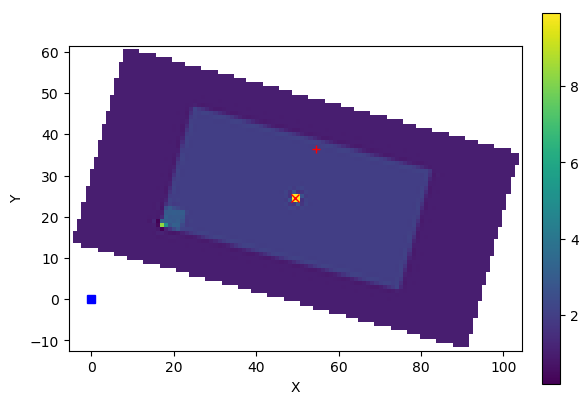

In [664]:
#reproduces rotate_data
#basic case: default rotate about xc,yc

data=a
x=None
y=None
args=[]
kwargs={}
fill_value=np.nan
ang=15
center=None #(xc,yc)

plt.clf()
#------------------

#establish data coordinates if not provided
if x is None: 
    x=np.arange(data.shape[1],dtype=float)
if y is None:
    y=np.arange(data.shape[0],dtype=float)

corners=list(itertools.product((x[0],x[-1]),(y[0],y[-1])))    
xc,yc=span(corners,axis=0).mean(axis=0)  #center of data in data coordinates
if center is None: #rotation center
    center=(xc,yc)  
step=x[1]-x[0],y[1]-y[0] #this is kept constant with rotation

#------------------

a3=ndimage.rotate(data,ang,reshape=1,cval=fill_value,*args,**kwargs)

x3=np.arange(a3.shape[1],dtype=float)*step[0]
y3=np.arange(a3.shape[0],dtype=float)*step[1]

#this is center of integer indices of rotated data, different from float center
#  of rotated corner span (can be calculated with matrix, see ipynb notebook
corners3=list(itertools.product((x3[0],x3[-1]),(y3[0],y3[-1])))
xc3,yc3=span(corners3,axis=0).mean(axis=0)


x0,y0=np.matmul(([[np.cos(th),np.sin(th)],[-np.sin(th),np.cos(th)]]),(np.array([xc,yc])-center)).T
#x0,y0=rotate_points((np.array([xc,yc])-center),ang*np.pi/180.,center=center) #rotation center transformed using points
print(x0,y0)
xout=x3-xc3+x0+center[0]  #(x3-xc3)*step[0]+center[0]
yout=y3-yc3+y0+center[1] #(y3-yc3)*step[1]+center[1]

#------------------    
print("center data original: ",xc,yc)
print("center image coord rotated: ",xc3,yc3)
print("corners:",corners)

ct=rotate_points(corners,-ang*np.pi/180.,center=center) #corners transformed using points
print("rotated:",np.around(ct,decimals=2))
xct,yct=span(ct,axis=0).mean(axis=0)
print("center of rotated corners: ",xct,yct)

#d2,x2,y2=rotate_data(a,x,y,ang=15,center=center)
plt.clf()
plot_data(a3,xout,yout) 
plt.plot(center[0],center[1],'xr')
plt.plot(xc3,yc3,'+r')
plt.plot(x0,y0,'sb')

plt.show()
display(plt.gcf())

Note here pixels are centered on integer coordinates (pixel index).

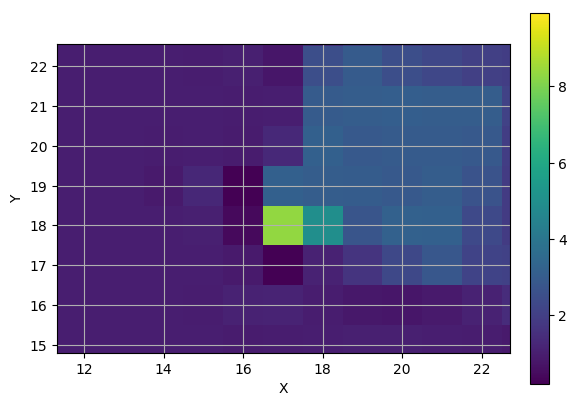

In [666]:
display(plt.gcf())

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109.] 54.5 32.247688029514066 20
center data original:  49.5 24.5
center image coord rotated:  54.5 36.5
corners: [(0.0, 0.0), (0.0, 49.0), (99.0, 0.0), (99.0, 49.0)]
rotated: [[ -1.91   5.52]
 [ 10.78  52.85]
 [ 93.72 -20.11]
 [106.4   27.22]]
center of rotated corners:  52.247688029514066 16.370762650667125


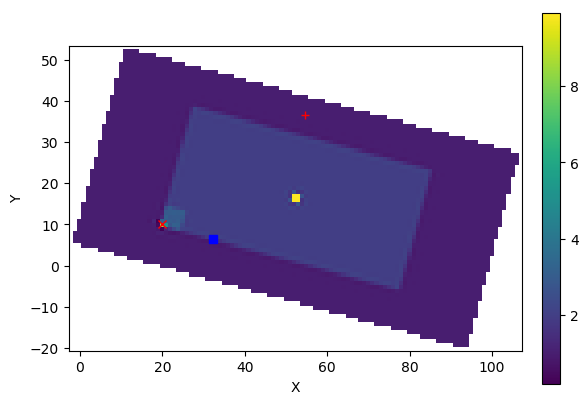

In [671]:
data=a
x=None
y=None
args=[]
kwargs={}
fill_value=np.nan
ang=15
center=(20,10)

plt.clf()
#------------------

#establish data coordinates if not provided
if x is None: 
    x=np.arange(data.shape[1],dtype=float)
if y is None:
    y=np.arange(data.shape[0],dtype=float)

corners=list(itertools.product((x[0],x[-1]),(y[0],y[-1])))    
xc,yc=span(corners,axis=0).mean(axis=0)  #center of data in data coordinates
if center is None: #rotation center
    center=(xc,yc)  
step=x[1]-x[0],y[1]-y[0] #this is kept constant with rotation

#------------------

a3=ndimage.rotate(data,ang,reshape=1,cval=fill_value,*args,**kwargs)
x3=np.arange(a3.shape[1],dtype=float)*step[0]
y3=np.arange(a3.shape[0],dtype=float)*step[1]

#this is center of integer indices of rotated data, different from float center
#  of rotated corner span (can be calculated with matrix, see ipynb notebook
corners3=list(itertools.product((x3[0],x3[-1]),(y3[0],y3[-1])))
xc3,yc3=span(corners3,axis=0).mean(axis=0)

th=ang/180*np.pi
#rotate distance vector of rotation center from scipy center 
x0,y0=np.matmul(([[np.cos(th),np.sin(th)],[-np.sin(th),np.cos(th)]]),(np.array([xc,yc])-center)).T
#x0,y0=rotate_points((np.array([xc,yc])-center),ang*np.pi/180.,center=center) #rotation center transformed using points
print(x3,(xc3),x0,center[0])
xout=x3-(xc3)+x0+center[0]  #(x3-xc3)*step[0]+center[0]
yout=y3-(yc3)+y0+center[1] #(y3-yc3)*step[1]+center[1]

#------------------    
print("center data original: ",xc,yc)
print("center image coord rotated: ",xc3,yc3)
print("corners:",corners)

ct=rotate_points(corners,-ang*np.pi/180.,center=center) #corners transformed using points
print("rotated:",np.around(ct,decimals=2))
xct,yct=span(ct,axis=0).mean(axis=0)
print("center of rotated corners: ",xct,yct)

#d2,x2,y2=rotate_data(a,x,y,ang=15,center=center)
plt.clf()
plot_data(a3,xout,yout) 
plt.plot(center[0],center[1],'xr')
plt.plot(xc3,yc3,'+r')
plt.plot(x0,y0,'sb')

plt.show()
display(plt.gcf())

With `rotate_points` integer coordinates are not centered on pixels.

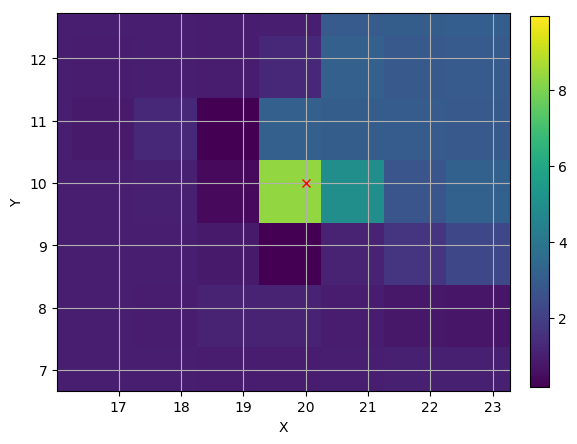

In [668]:
display(plt.gcf())

resampling...
resampling...


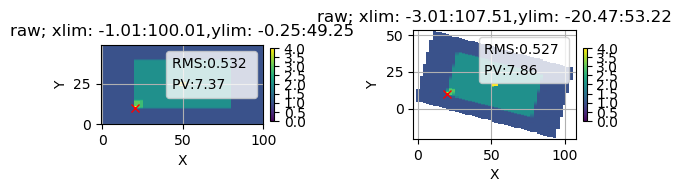

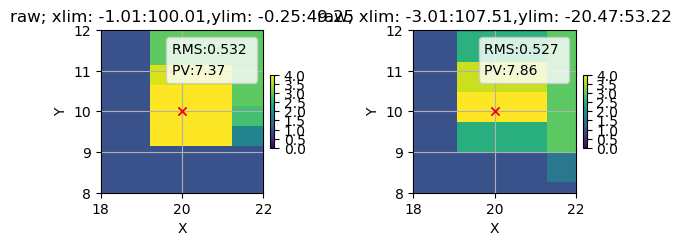

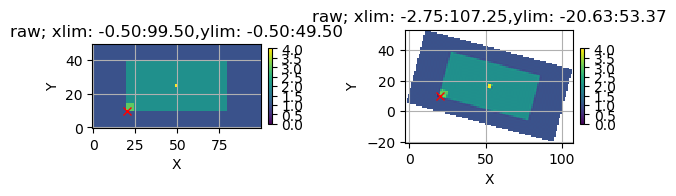

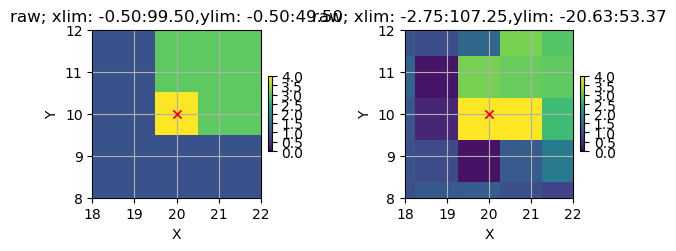

In [678]:
# basic test, rotate about 20,10
test_rotate_points(a,ang=15,center=center,dx=2,dy=2)  #baseline
test_rotate_center(a,x,y,ang=15.,center=center,dx=2,dy=2)

resampling...
resampling...


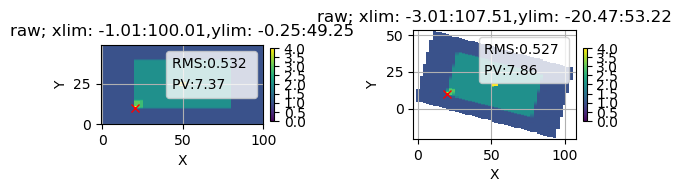

In [649]:
#try to solve on rotate_data
plt.close('all')
test_rotate_center(a,x,y,ang=15,center=(20,10),dx=2,dy=2,nozoom=1)
plt.show()

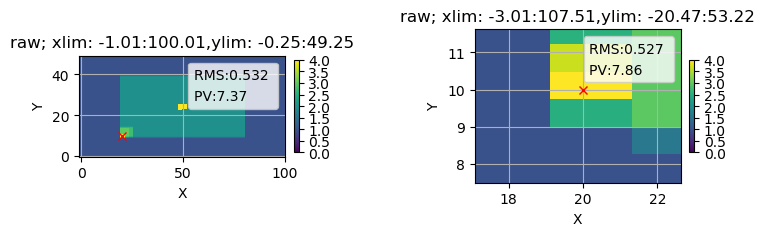

In [650]:
display(plt.gcf())

In [477]:
plt.close('all')

Test it is not altering rotation center:

In [458]:
print(xc,yc,rotate_points([[xc,yc]],-15*np.pi/180.))

49.5 24.5 [[54.15439501 10.85364001]]


In [459]:
print(xc,yc,rotate_points([[xc,yc]],-15*np.pi/180.,center=(xc,yc)))

49.5 24.5 [[49.5 24.5]]


In [460]:
x0,y0=20,10
print(x0,y0,rotate_points([[x0,y0]],-15*np.pi/180.,center=(x0,y0)))

20 10 [[20. 10.]]


In [500]:
data=a
x=None
y=None
args=[]
kwargs={}
fill_value=np.nan

In [501]:
#establish data coordinates if not provided
if x is None: 
    x=np.arange(data.shape[1],dtype=float)
if y is None:
    y=np.arange(data.shape[0],dtype=float)

corners=list(itertools.product((x[0],x[-1]),(y[0],y[-1])))    
xc,yc=span(corners,axis=0).mean(axis=0)  #center of data in data coordinates
if center is None: #rotation center
    center=(xc,yc)  
step=x[1]-x[0],y[1]-y[0] #this is kept constant with rotation

In [502]:
a3=ndimage.rotate(data,ang,reshape=1,cval=fill_value,*args,**kwargs)
x3=np.arange(a3.shape[1],dtype=float)
y3=np.arange(a3.shape[0],dtype=float)

#this is center of integer indices of rotated data, different from float center
#  of rotated corner span (can be calculated with matrix, see ipynb notebook
corners3=list(itertools.product((x3[0],x3[-1]),(y3[0],y3[-1])))
xc3,yc3=span(corners3,axis=0).mean(axis=0)

th=ang/180*np.pi
x0,y0=np.matmul(([[np.cos(th),np.sin(th)],[-np.sin(th),np.cos(th)]]),(np.array([xc,yc])-center)).T
#x0,y0=rotate_points((np.array([xc,yc])-center),ang*np.pi/180.,center=center) #rotation center transformed using points
print(x0,y0)
xout=x3-xc3+x0+center[0]  #(x3-xc3)*step[0]+center[0]
yout=y3-yc3+y0+center[1] #(y3-yc3)*step[1]+center[1]
ct=rotate_points(corners,-ang*np.pi/180.,center=center) #corners transformed using points

32.247688029514066 6.370762650667128


0.0 0.0


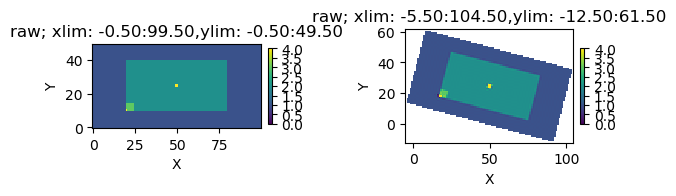

In [503]:
plt.figure()
plt.subplot(121)
plot_data(a)
plt.title("raw; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
plt.clim([0,4])
plt.subplot(122)
d2,x2,y2=rotate_data(a,x,y,15)
plot_data(d2,x2,y2)  
plt.title("raw; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
plt.clim([0,4])
plt.tight_layout()
display(plt.gcf())

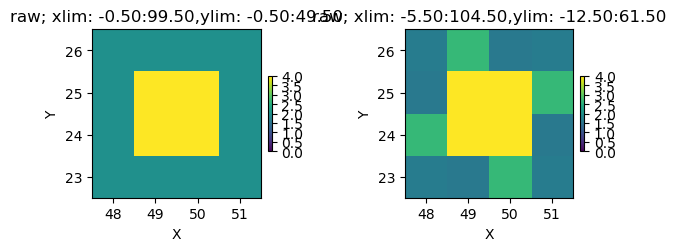

In [504]:
for ax in plt.gcf().axes[::2]:
    ax.set_xlim((xc-dx,xc+dx))
    ax.set_ylim((yc-dy,yc+dy))
    
display(plt.gcf())

In [505]:
"""
# use ndimage to rotate data and recalculate coordinate 
#this assumes same center and non-integer coordinates are interpolated on integer cordinates 
#   (in units of steps) 
# default cval = 0.0 
a3=ndimage.rotate(data,ang,reshape=1)

#coordinates of rotated matplotlib center analytically calculated from original
#in index coordinates of rotated data. Same as measure span between corners.   
th=ang*np.pi/180
xc3,yc3=np.matmul(np.array([[np.cos(th),np.sin(th)],
                     [np.sin(th),np.cos(th)]]),np.array([xc,yc]))

#rotated matplotlib coordinates as indices
x3=np.arange(a3.shape[1],dtype=float)
y3=np.arange(a3.shape[0],dtype=float)

#output coordinates
xout=x3*step-xc3+xc
yout=y3*step-yc3+yc
print("cane")
""";

Plot rotated corners over data. Rotation is about central point (middle point of coordinates span).

Corners are rotated with `rotate_points`, data with `ndimage.rotate`.
corners coordinates are offset by `-xct+xc3` (and y..) to match matplotlib index,
where `xct` is original center, and `xc3` center of rotated data in plotted data index space:

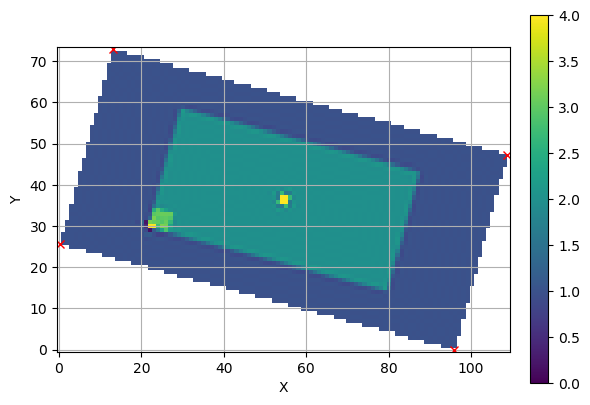

In [506]:
plt.figure('match_corners')

ct[:,0]=ct[:,0]
ct[:,1]=ct[:,1]

plt.clf()
plot_data(a3,vmin=0,vmax=4)
plt.plot(ct[:,0]-xct+xc3,ct[:,1]-yct+yc3,'xr')  #translate ct to common center
ax=plt.gca()
plt.grid(1)

display(plt.gcf())

In [507]:
#attempt to make ticks thick on cell borders and thin on points
# fails because major and minor grid overlap and thicker line prevails
#ax.set_xticks(np.arange(0, 101, 20))
#ax.set_xticks(minor_ticks, minor=True)
#ax.set_yticks(np.arange(0, 101, 10))
#ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
#ax.grid(which='both')

# Or if you want different settings for the grids:
#ax.grid(which='minor', alpha=0.2)
#ax.grid(which='major', alpha=0.5)

#ax.set_xticks(np.arange(0, 101, 1))
#ax.set_yticks(np.arange(0, 101, 1))
#ax.set_xticks(np.arange(0, 101, 0.5),minor=True)
#ax.set_yticks(np.arange(0, 101, 0.5),minor=True)
# Or if you want different settings for the grids:
#ax.grid(which='minor', alpha=0.5, linestyle='solid', lw =2)
#ax.grid(which='major', alpha=0.1, linestyle='dotted')

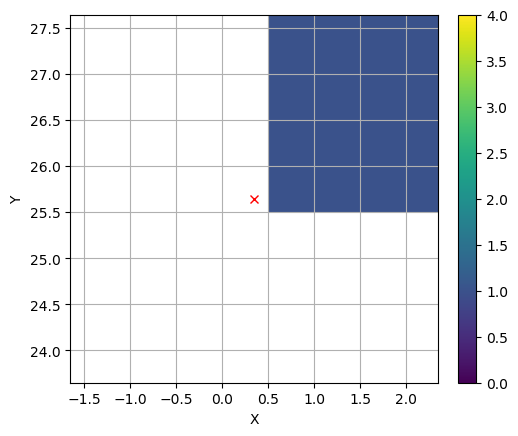

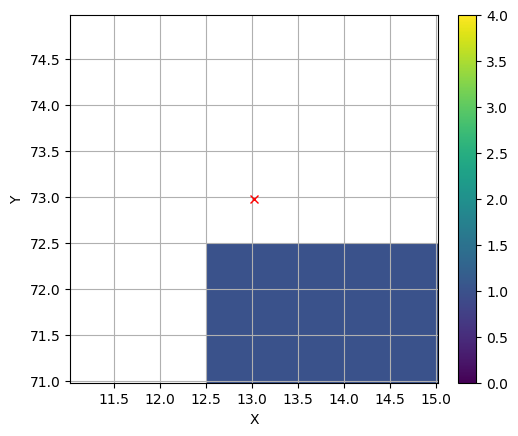

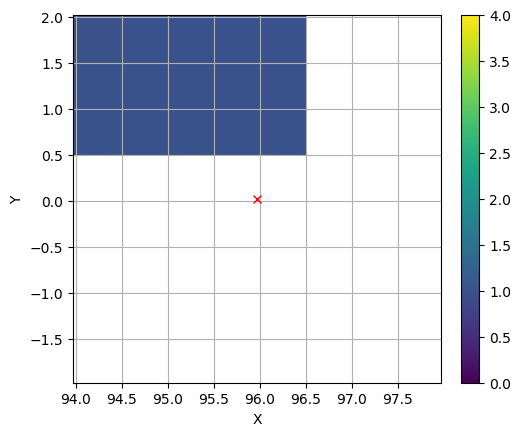

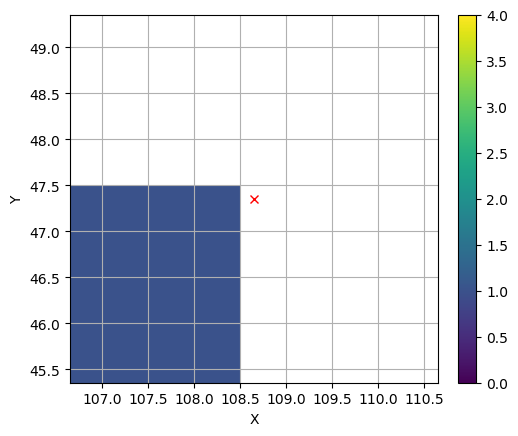

In [508]:
dx,dy=2,2

for c in ct:
    plt.xlim([c[0]-dx-xct+xc3,c[0]+dx-xct+xc3])
    plt.ylim([c[1]-dy-yct+yc3,c[1]+dy-yct+yc3])
    plt.draw()
    display(plt.gcf())

    from itertools import product

    # use ndimage to rotate data and recalculate coordinate 
    #this assumes same center and non-integer coordinates are interpolated on integer cordinates 
    #   (in units of steps) 
    # default cval = 0.0 
    a3=ndimage.rotate(data,ang,reshape=1,cval=fill_value,*args,**kwargs)
    x3=np.arange(a3.shape[1],dtype=float)
    y3=np.arange(a3.shape[0],dtype=float)
    
    #this is center of integer indices of rotated data, different from float center
    #  of rotated corner span (can be calculated with matrix, see ipynb notebook
    corners3=list(itertools.product((x3[0],x3[-1]),(y3[0],y3[-1])))
    xc3,yc3=span(corners3,axis=0).mean(axis=0)

    xout=(x3-xc3)*step[0]-xc+center[0]
    yout=(y3-yc3)*step[1]-yc+center[1]

32.247688029514066 6.370762650667128


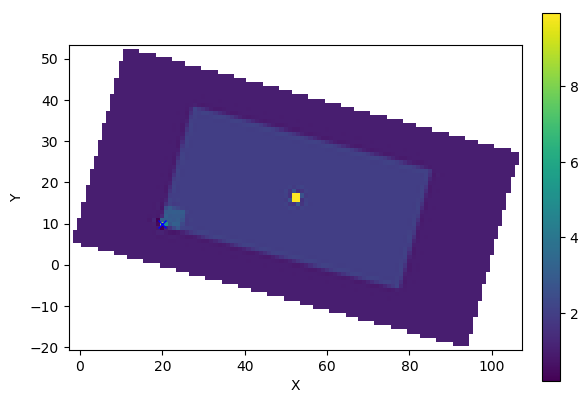

In [510]:
center=(20,10)
d2,x2,y2=rotate_data(a,x,y,ang=15,center=center)
plt.clf()
plot_data(d2,x2,y2) 
plt.plot(center[0],center[1],'xb')
display(plt.gcf())

In [511]:
plt.close('all')

Next plots show the results of this alignment applied to rotation about center of data, zoom on rotation center allows to verify centering:

Define above plots as function and apply to more generic cases:

In [512]:
# reproduce case #1 using function
#test_rotate_center(a,ang=15)

Rotate about hit pixel at (20,10)

32.247688029514066 6.370762650667128


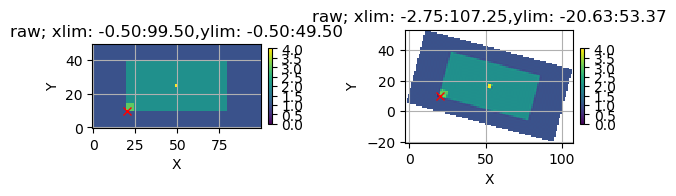

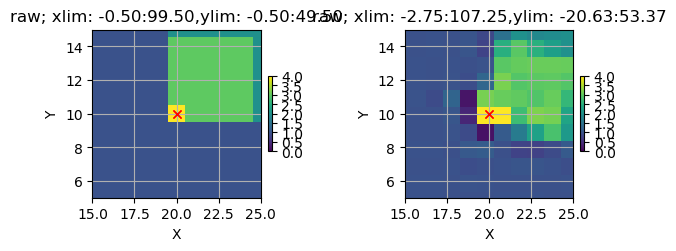

In [634]:
test_rotate_center(a,ang=15,center=(20,10),dx=5,dy=5)

It should give same result using points (replot first reference result):

In [514]:
from pySurf.data2D import rotate_data

In [515]:
from pySurf.points import matrix_to_points2, plot_points, points_find_grid
from pySurf.points import save_points, get_points, points_autoresample

In [679]:
plt.close('all')
def test_rotate_points(a,x=None,y=None,nozoom=False,dx=2,dy=2,center=None,scatter=False,*args,**kwargs):
    
    #dx,dy=2,2 #margin for zoom  
    crange=[0,4]

    #establish data coordinates if not provided
    if x is None: 
        x=np.arange(data.shape[1],dtype=float)
    if y is None:
        y=np.arange(data.shape[0],dtype=float)

    corners=list(itertools.product((x[0],x[-1]),(y[0],y[-1])))    
    xc,yc=span(corners,axis=0).mean(axis=0)  #center of data in data coordinates
    if center is None: #rotation center
        center=(xc,yc)  
    p=matrix_to_points2(a,x,y)
    theta=-kwargs.pop('ang',0)/180*np.pi
    p2=rotate_points(p,theta,center=center,*args,**kwargs)
        #this assumes same center and non-integer coordinates are interpolated on integer cordinates 
    #   (in units of steps) 

    #xout,yout=points_find_grid(p2,result='grid',steps=(0,0))
    #d2,x2,y2=points_autoresample(p2,steps=(0,0))
    
    #d2,x2,y2=rotate_data(a,x,y,*args,**kwargs)

    #plot original data
    plt.figure()
    plt.subplot(121)
    plot_points(p,scatter=scatter)
    plt.title("raw; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
    plt.clim(*crange)
    plt.plot(center[0],center[1],'xr')    
    plt.grid(1)
    
    #plot rotated data
    plt.subplot(122)
    plot_points(p2,scatter=scatter)  
    plt.title("raw; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
    plt.clim(*crange)
    plt.plot(center[0],center[1],'xr')
    plt.grid(1)
    
    plt.tight_layout()
    display(plt.gcf()) 

    if not nozoom:
        #zoom on rotation center
        xc,yc= kwargs.get('center',[span(p2[0,:]).mean(),span(p2[1,:]).mean()])
        for ax in plt.gcf().axes[::2]:
            plt.sca(ax)
            plt.xlim((center[0]-dx,center[0]+dx))
            plt.ylim((center[1]-dy,center[1]+dy))
            plt.plot(center[0],center[1],'xr')
            plt.grid(1)
            #ax.set_xlim((xc-dx,xc+dx))
            #ax.set_ylim((yc-dy,yc+dy))
        display(plt.gcf())

In [680]:
def test_rotate_center(a,x=None,y=None,nozoom=False,dx=2,dy=2,center=None,*args,**kwargs):
    
    #establish data coordinates if not provided
    if x is None: 
        x=np.arange(data.shape[1],dtype=float)
    if y is None:
        y=np.arange(data.shape[0],dtype=float)

    corners=list(itertools.product((x[0],x[-1]),(y[0],y[-1])))    
    xc,yc=span(corners,axis=0).mean(axis=0)  #center of data in data coordinates
    if center is None: #rotation center
        center=(xc,yc)  
    
    #dx,dy=2,2 #margin for zoom  
    crange=[0,4]
    d2,x2,y2=rotate_data(a,x,y,center=center,*args,**kwargs)
    
    #plot original data
    plt.figure()
    plt.subplot(121)
    plot_data(a,x,y)
    plt.title("raw; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
    plt.clim(*crange)
    plt.plot(center[0],center[1],'xr')
    plt.grid(1)
    
    #plot rotated data
    plt.subplot(122)
    plot_data(d2,x2,y2)  
    plt.title("raw; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
    plt.clim(*crange)
    plt.plot(center[0],center[1],'xr')
    plt.grid(1)
    plt.tight_layout()
    display(plt.gcf()) 
    
    if not nozoom:
        #zoom on rotation center
        xc,yc= kwargs.get('center',[span(x2).mean(),span(y2).mean()])
        for ax in plt.gcf().axes[::2]:
            plt.sca(ax)
            plt.xlim((center[0]-dx,center[0]+dx))
            plt.ylim((center[1]-dy,center[1]+dy))
            plt.plot(center[0],center[1],'xr')
            plt.grid(1)
            #ax.set_xlim((xc-dx,xc+dx))
            #ax.set_ylim((yc-dy,yc+dy))
        display(plt.gcf())
    

resampling...
resampling...


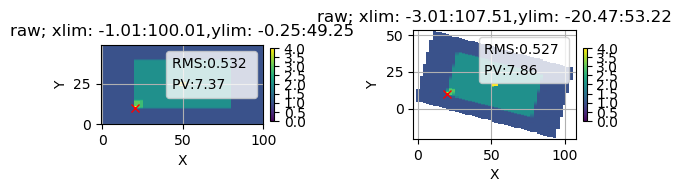

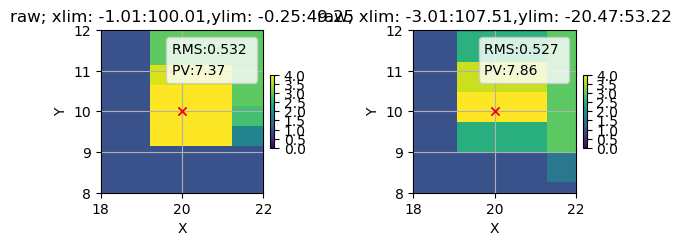

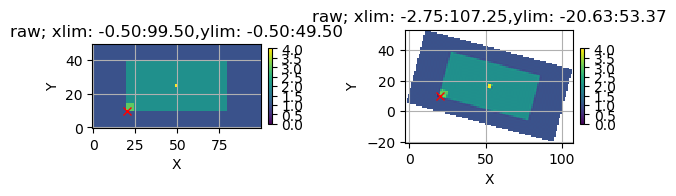

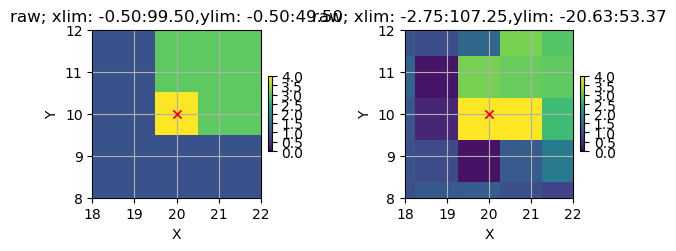

In [684]:
# basic test, rotate about 20,10
test_rotate_points(a,x,y,ang=15,center=(20,10),dx=2,dy=2)  #baseline
test_rotate_center(a,ang=15.,center=(20,10),dx=2,dy=2)

resampling...
resampling...


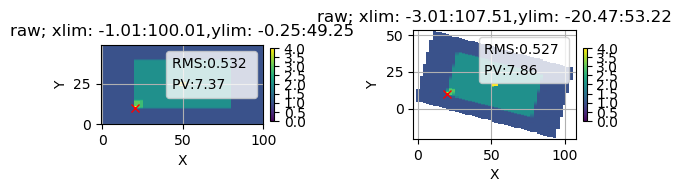

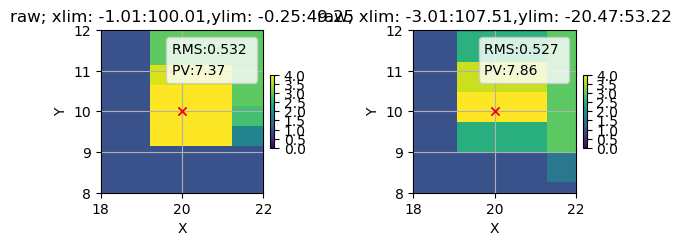

resampling...
resampling...


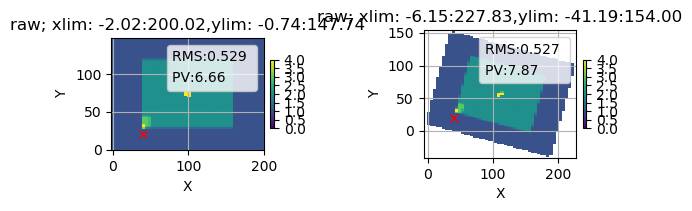

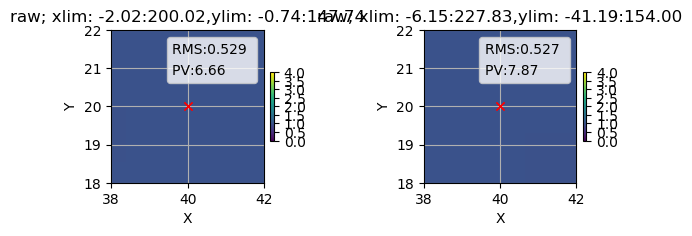

70.8364426640399 36.40670804541644


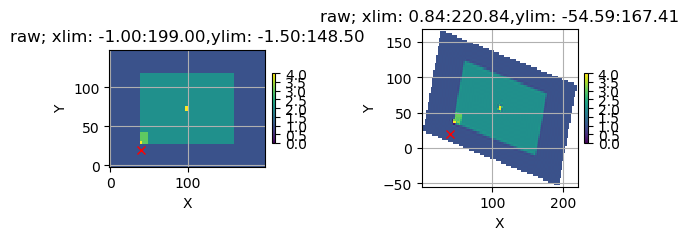

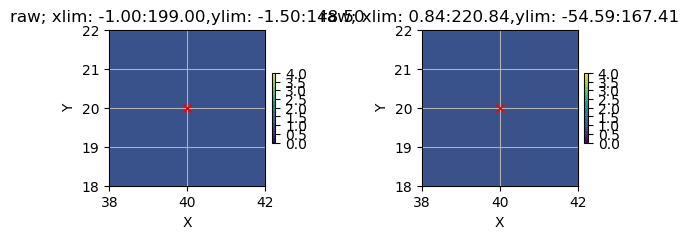

In [631]:
#test scale
test_rotate_points(a,x,y,ang=15,center=(20,10),dx=2,dy=2)
test_rotate_points(a,x*2,y*3,ang=15,center=(40,20),dx=2,dy=2)
test_rotate_center(a,x*2,y*3,ang=15.,center=(40,20),dx=2,dy=2)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


resampling...
resampling...


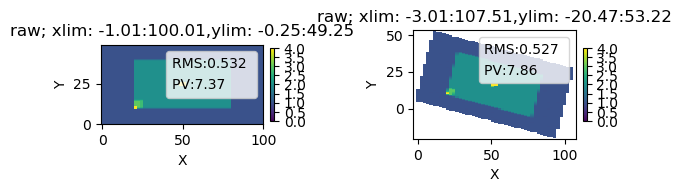

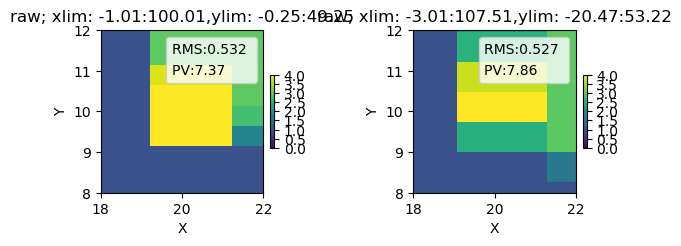

resampling...
resampling...


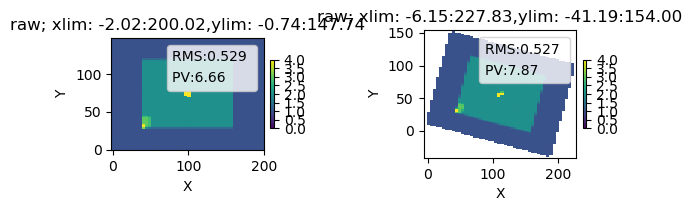

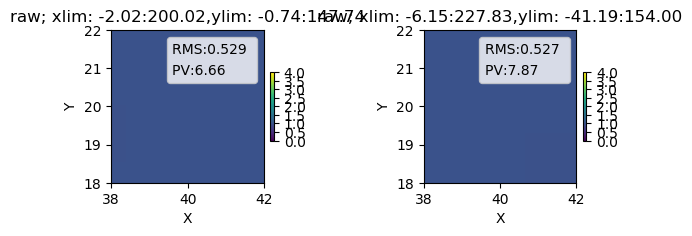

32.247688029514066 6.370762650667128


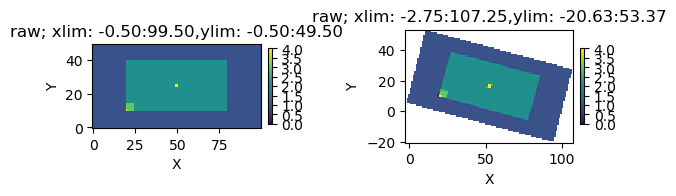

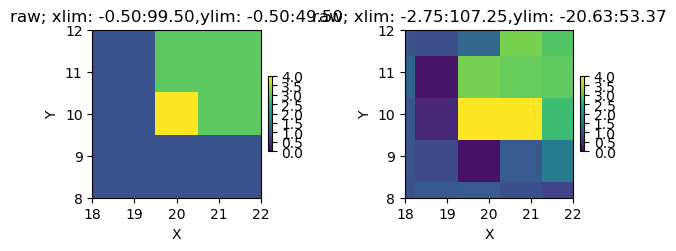

92.74314964084647 40.8895854062567


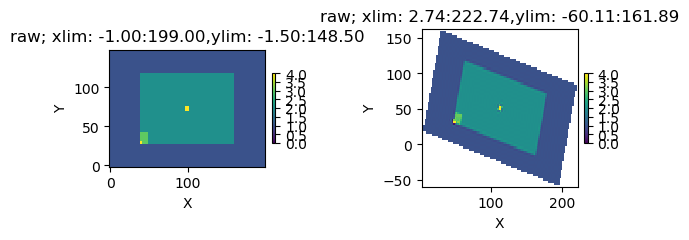

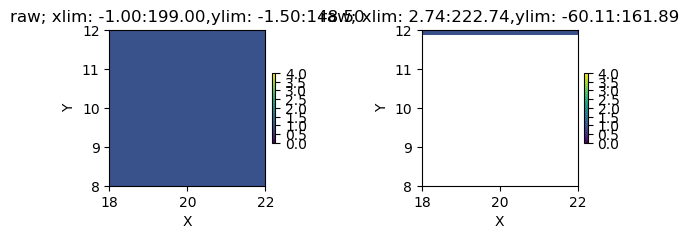

In [601]:
test_rotate_points(a,x,y,ang=15,center=(20,10),dx=2,dy=2)
test_rotate_points(a,x*2,y*3,ang=15,center=(40,20),dx=2,dy=2)
test_rotate_center(a,ang=15.,center=(20,10),dx=2,dy=2)
test_rotate_center(a,x*2,y*3,ang=15.,center=(20,10),dx=2,dy=2)

32.247688029514066 6.370762650667128


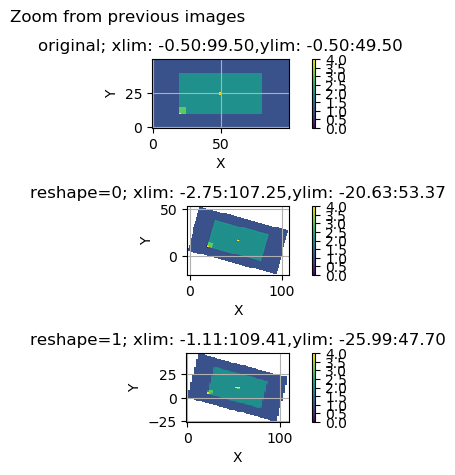

In [547]:
plt.figure()

ax1=plt.subplot(311)
plot_data(a1,vmin=0,vmax=4)
#ax1.set_xlim([17,25])
#ax1.set_ylim([8,16])
plt.title("original; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
plt.grid(1)

ax2=plt.subplot(312)
plot_data(*rotate_data(a,x,y,ang=15,center=(20,10)),vmin=0,vmax=4)
#ax2.set_xlim([15,23])
#ax2.set_ylim([16,24])
plt.title("reshape=0; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
plt.grid(1)

ax3=plt.subplot(313)
plot_data(*rotate_data(a,x,y,ang=15,center=(20,10),usepoints=True),vmin=0,vmax=4)
#ax3.set_xlim([20,28])
#ax3.set_ylim([28,36])
plt.title("reshape=1; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
plt.grid(1)
plt.tight_layout(rect=[0,0,1,0.95])

#plt.suptitle("expected projected side lengths %.3f, %.3f"%(nx*np.cos(rotang*np.pi/180)+ny*np.sin(15*np.pi/180),ny*np.cos(rotang*np.pi/180)+nx*np.sin(rotang*np.pi/180)))
plt.suptitle("Zoom from previous images")
plt.show()
display(plt.gcf())

32.247688029514066 6.370762650667128


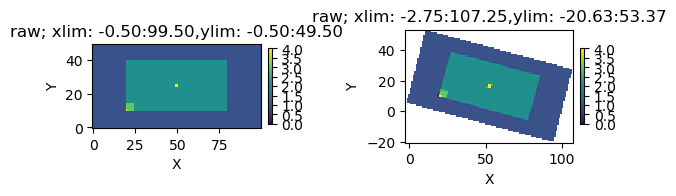

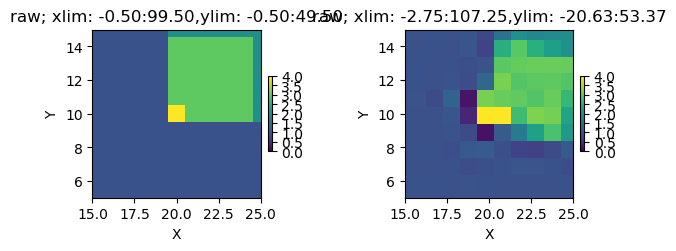

In [568]:
test_rotate_center(a,ang=15.,center=(20,10),dx=5,dy=5)

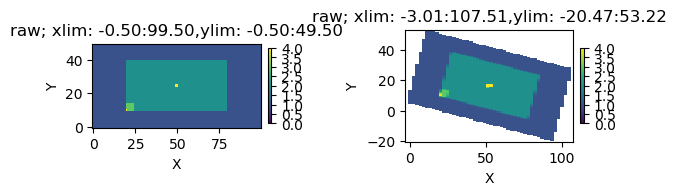

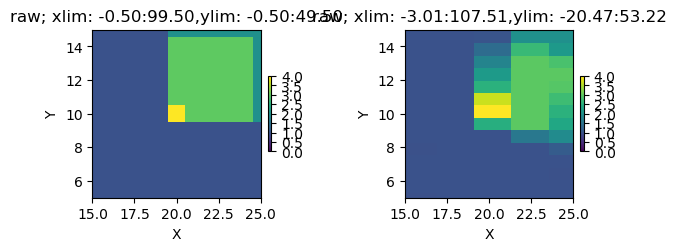

In [569]:
test_rotate_center(a,ang=15.,center=(20,10),usepoints=True,dx=5,dy=5)

54.15439500632064 10.853640011507396


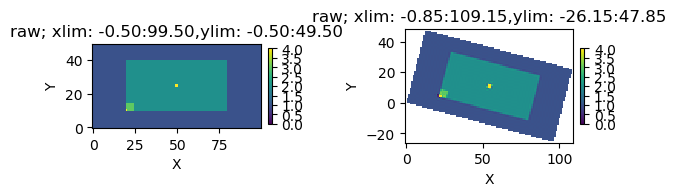

In [589]:
test_rotate_center(a,x,y,ang=15.,center=(0,0),dx=5,dy=5,nozoom=1)

In [102]:
#development test of rotate_data coordinates mapping

center=None
data=a
ang=15

 
xc,yc=span(corners,axis=0).mean(axis=0)
if center is None:
    center=(xc,yc)
step=x[1]-x[0],y[1]-y[0] #this is kept constant with rotation

# use ndimage to rotate data and recalculate coordinate 
#this assumes same center and non-integer coordinates are interpolated on integer cordinates 
#   (in units of steps) 
# default cval = 0.0 
a3=ndimage.rotate(data,ang,reshape=1)

#coordinates of rotated matplotlib center analytically calculated from original 
xc3,yc3=np.matmul(np.array([[np.cos(th),np.sin(th)],
                     [np.sin(th),np.cos(th)]]),np.array([xc,yc]))

#rotated matplotlib coordinates as indices
x3=np.arange(a3.shape[1],dtype=float)
y3=np.arange(a3.shape[0],dtype=float)

#it would be better to obtain those by transformation of original corners and rescaling with steps as
#done somewhere in notebook.
#corners3=list(itertools.product((x3[0],x3[-1]),(y3[0],y3[-1])))
#xc3,yc3=span(corners3,axis=0).mean(axis=1)

xout=(x3-xc3)*step[0]+xc
yout=(y3-yc3)*step[1]+yc

print("xout,yout:" ,xout,yout)
th=ang/180*np.pi

print ("Center from span of rotated corners:",
      xc3,yc3)
# note: np.dstack([a,b]).squeeze() with a and b 2el crashes kernel
print("center of mpl rotated data",
      span((np.matrix([[np.cos(th),np.sin(th)],[np.sin(th),np.cos(th)]])*
                np.asarray(corners).T).T,axis=0)[1]/2)

xout,yout: [ -4.65439501  -3.65439501  -2.65439501  -1.65439501  -0.65439501
   0.34560499   1.34560499   2.34560499   3.34560499   4.34560499
   5.34560499   6.34560499   7.34560499   8.34560499   9.34560499
  10.34560499  11.34560499  12.34560499  13.34560499  14.34560499
  15.34560499  16.34560499  17.34560499  18.34560499  19.34560499
  20.34560499  21.34560499  22.34560499  23.34560499  24.34560499
  25.34560499  26.34560499  27.34560499  28.34560499  29.34560499
  30.34560499  31.34560499  32.34560499  33.34560499  34.34560499
  35.34560499  36.34560499  37.34560499  38.34560499  39.34560499
  40.34560499  41.34560499  42.34560499  43.34560499  44.34560499
  45.34560499  46.34560499  47.34560499  48.34560499  49.34560499
  50.34560499  51.34560499  52.34560499  53.34560499  54.34560499
  55.34560499  56.34560499  57.34560499  58.34560499  59.34560499
  60.34560499  61.34560499  62.34560499  63.34560499  64.34560499
  65.34560499  66.34560499  67.34560499  68.34560499  69.34560499

In [634]:
p=matrix_to_points2(a,x,y)
plt.close('all')
plot_points(p);plt.show()
plt.figure()
p=rotate_points(p,-15/180*np.pi,center=(20,10))
plot_points(p);plt.show()
res=points_autoresample(p)
res
plt.figure()
plot_data(*res);plt.show()

resampling...
resampling...


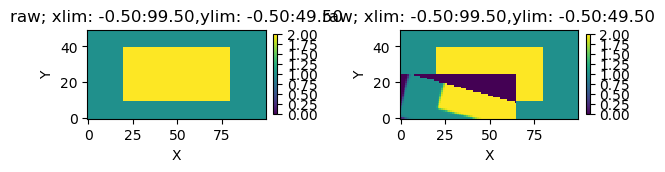

In [43]:
def rot01(img, angle, pivot):
    from scipy import ndimage
    # https://www.programcreek.com/python/example/93921/scipy.ndimage.rotate
    # ex. nr. 1
    pivot = np.array(pivot).astype(np.int32)
    # double size of image while centering object
    pads = [[img.shape[0] - pivot[0], pivot[0]], [img.shape[1] - pivot[1], pivot[1]]]
    if len(img.shape) > 2:
        pads.append([0, 0])
    imgP = np.pad(img, pads, 'constant')
    # reduce size of matrix to rotate around the object
    if len(img.shape) > 2:
        total_y = np.sum(imgP.any(axis=(0, 2))) * 2.4
        total_x = np.sum(imgP.any(axis=(1, 2))) * 2.4
    else:
        total_y = np.sum(imgP.any(axis=0)) * 2.4
        total_x = np.sum(imgP.any(axis=1)) * 2.4
    cropy = int((imgP.shape[0] - total_y)/2)
    cropx = int((imgP.shape[1] - total_x)/2)
    imgP[cropy:-cropy, cropx:-cropx] = \
        ndimage.rotate(imgP[cropy:-cropy, cropx:-cropx], angle,
        reshape=False, prefilter=False)

    return imgP[pads[0][0]: -pads[0][1], pads[1][0]: -pads[1][1]] 


#from pySurf.instrumentReader import points_reader

#infolder=r'test\input_data\profilometer\04_test_directions'
#infile='07_xysurf_mp_Intensity.txt'

#data,x,y=points_reader(os.path.join(infolder,infile))

img=a
angle=30/180*np.pi
pivot=(5,5)

plt.figure()
plt.subplot(121)
plot_data(a)
plt.title("raw; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
plt.clim([0,2])
plt.subplot(122)
d2=rot01(a,15,np.array((5,5)))
plot_data(d2)  
plt.title("raw; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
plt.clim([0,2])
plt.tight_layout()
display(plt.gcf())


In [14]:
infolder=r'input_data\profilometer\04_test_directions'
#outfolder=r'test\profilometer_scans\04_test_directions_output'
outfolder=r'results\test_points'
testfiles=['05_xysurf_pp_Intensity.txt','06_xysurf_pm_Intensity.txt','07_xysurf_mp_Intensity.txt',
          '08_xysurf_mm_Intensity.txt','09_yxsurf_pp_Intensity.txt','10_yxsurf_pm_Intensity.txt',
          '11_yxsurf_mp_Intensity.txt','12_yxsurf_mm_Intensity.txt']
#definition for subplots
n=len(testfiles)
a = np.floor(n**0.5).astype(int) #nr of plots on horizontal
b = np.ceil(1.*n/a).astype(int) #nr of plots on vertical 

## rotate and rebin

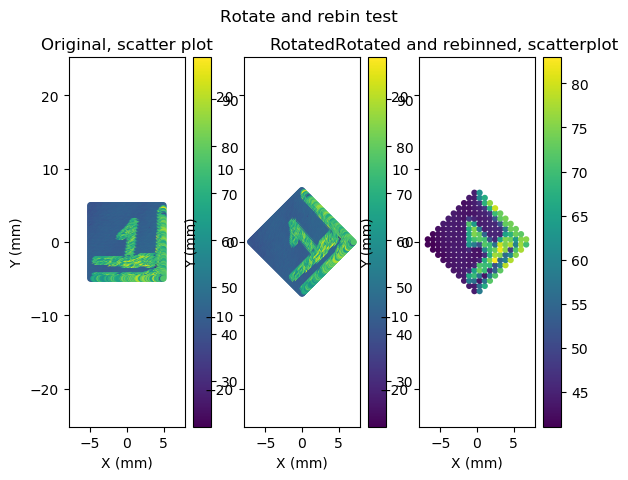

In [31]:
pts2=rotate_points(pts,45*np.pi/180)  #rotate 45 degrees
pts3=rebin_points(pts2,bins=nbins)

fig=plt.figure(8)
plt.clf()
plt.suptitle('Rotate and rebin test')
plt.subplot(131)
plt.title('Original, scatter plot')
plot_points(pts,scatter=1,aspect='equal')
ax1=plt.gca()
plt.subplot(132,sharex=ax1,sharey=ax1)
plt.title('Rotated')
plot_points(pts2,scatter=1,aspect='equal')
plt.subplot(133,sharex=ax1,sharey=ax1)
plt.title('Rotated and rebinned, scatterplot')
plot_points(pts3,scatter=1,aspect='equal')
plt.savefig(os.path.join(outfolder,'08_rotateandrebin.png'))
display(plt.gcf())

In [32]:
plt.close('all')

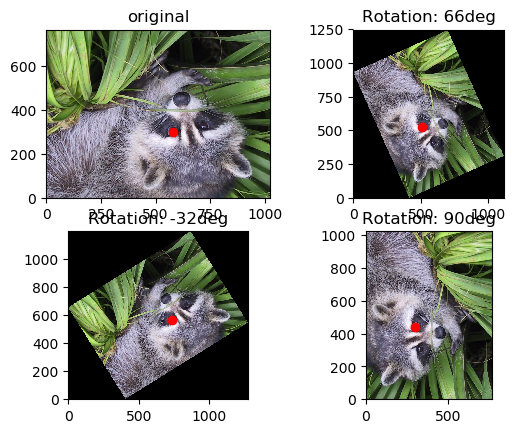

In [256]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy.ndimage import rotate

data_orig = misc.face()
x0,y0 = 580,300 # left eye; (xrot,yrot) should point there

def rot(image, xy, angle):
    im_rot = rotate(image,angle) 
    org_center = (np.array(image.shape[:2][::-1])-1)/2.
    rot_center = (np.array(im_rot.shape[:2][::-1])-1)/2.
    org = xy-org_center
    a = np.deg2rad(angle)
    new = np.array([org[0]*np.cos(a) + org[1]*np.sin(a),
            -org[0]*np.sin(a) + org[1]*np.cos(a) ])
    return im_rot, new+rot_center


fig,axes = plt.subplots(2,2)

axes[0,0].imshow(data_orig,origin='lower')
axes[0,0].scatter(x0,y0,c="r" )
axes[0,0].set_title("original")

for i, angle in enumerate([66,-32,90]):
    data_rot, (x1,y1) = rot(data_orig, np.array([x0,y0]), angle)
    axes.flatten()[i+1].imshow(data_rot,origin='lower')
    axes.flatten()[i+1].scatter(x1,y1,c="r" )
    axes.flatten()[i+1].set_title("Rotation: {}deg".format(angle))

plt.show()
display(plt.gcf())


    #PIL rotate
    https://pillow.readthedocs.io/en/3.1.x/reference/Image.html
    Image.rotate(angle, resample=0, expand=0)

    Returns a rotated copy of this image. This method returns a copy of this image, rotated the given number of degrees counter clockwise around its centre.
    Parameters:	

        angle – In degrees counter clockwise.
        resample – An optional resampling filter. This can be one of PIL.Image.NEAREST (use nearest neighbour), PIL.Image.BILINEAR (linear interpolation in a 2x2 environment), or PIL.Image.BICUBIC (cubic spline interpolation in a 4x4 environment). If omitted, or if the image has mode “1” or “P”, it is set PIL.Image.NEAREST.
        expand – Optional expansion flag. If true, expands the output image to make it large enough to hold the entire rotated image. If false or omitted, make the output image the same size as the input image.

    Returns:	

    An Image object.

https://stackoverflow.com/questions/14163211/rotation-in-python-with-ndimage


SciPy's rotate defaults to cubic spline interpolation, while PIL's defaults to nearest neighbor. If you add the keyword parameter order=0 to SciPy, it should speed up considerably, and if you add filter=PIL.Image.BICUBIC (which is equivalent to filter=3) to PIL it will slow down. It is always a good idea to read the docs: docs.scipy.org/doc/scipy/reference/generated/… and pythonware.com/library/pil/handbook/image.htm



